# Homework
## Preparing the data

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [133]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [134]:
feature_cols = [
	'engine_displacement',
	'horsepower',
	'vehicle_weight',
	'model_year',
	'fuel_efficiency_mpg'
]
df = df.loc[:, feature_cols]

## EDA

In [135]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


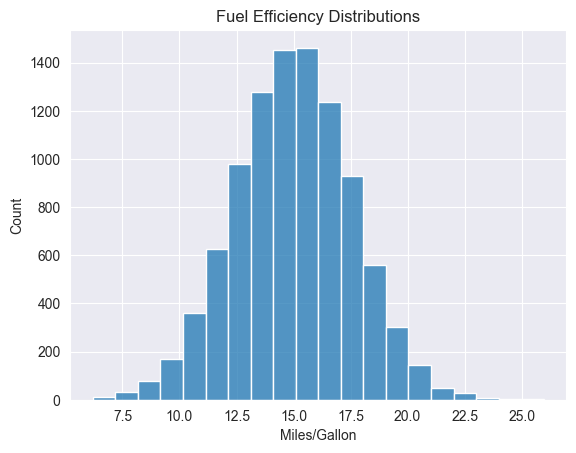

In [136]:
sns.histplot(df, x="fuel_efficiency_mpg", bins=20)
plt.title("Fuel Efficiency Distributions")
plt.xlabel("Miles/Gallon")
plt.show()

> The `fuel_efficiency_mpg` does not show significant skew

### Question 1
There's one column with missing values. What is it?

In [137]:
print("Columns with missing values:", list(df.columns[df.isna().sum() > 0]))

Columns with missing values: ['horsepower']


### Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [138]:
print("Median of the 'horsepower' variable: ", df.horsepower.median())

Median of the 'horsepower' variable:  149.0


## Splitting the dataset

In [139]:
def data_split(df, seed):
	np.random.seed(seed)

	n = df.shape[0]

	n_val = n_test = int(0.2 * n)
	n_train = n - (n_val + n_test)

	idx = np.arange(n)
	np.random.shuffle(idx)

	df_shuffled = df.iloc[idx]

	df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)
	df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop=True)
	df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop=True)

	return df_train, df_val, df_test

In [140]:
df_train, df_val, df_test = data_split(df, 42)

In [141]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

df_train.drop('fuel_efficiency_mpg', axis=1, inplace=True, errors='ignore')
df_val.drop('fuel_efficiency_mpg', axis=1, inplace=True, errors='ignore')
df_test.drop('fuel_efficiency_mpg', axis=1, inplace=True, errors='ignore')

In [142]:
assert df_val.shape == df_test.shape

### Question 3
Which imputation method yields the bestter model?

#### Model 1: Replace missing values with 0

In [143]:
def train_linear_regression(X, y):
	ones = np.ones(X.shape[0])
	X = np.column_stack([ones, X])

	XTX = X.T.dot(X)
	XTX_inv = np.linalg.inv(XTX)
	w = XTX_inv.dot(X.T).dot(y)

	return w[0], w[1:]

In [144]:
def rmse(y, y_pred):
	error = y_pred - y
	mse = (error ** 2).mean()
	return np.sqrt(mse)

In [145]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_train = df_train[base].fillna(0)
w_0, w = train_linear_regression(X_train, y_train)

In [146]:
X_val = df_val[base].fillna(0)
y_pred = w_0 + X_val.dot(w)

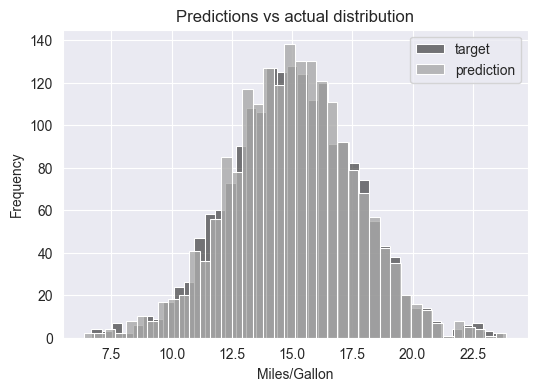

In [147]:
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Miles/Gallon')
plt.title('Predictions vs actual distribution')

plt.show()

In [148]:
print(f"{rmse(y_val, y_pred):.3}")

0.517


#### Model 2: Replace missing values with feature's mean value

In [149]:
X_train = df_train[base]
m = X_train.horsepower.mean()
X_train.horsepower = X_train.horsepower.fillna(m)
w_0, w = train_linear_regression(X_train, y_train)

In [150]:
X_val = df_val[base]
X_val.horsepower = X_val.horsepower.fillna(m)
y_pred = w_0 + X_val.dot(w)

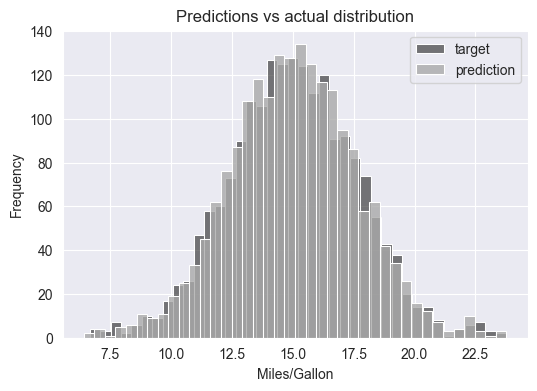

In [151]:
plt.figure(figsize=(6, 4))

sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Miles/Gallon')
plt.title('Predictions vs actual distribution')

plt.show()

In [152]:
print(f"{rmse(y_val, y_pred):.3}")

0.464


### Question 4

In [153]:
def train_linear_regression_reg(X, y, r=0.0):
	ones = np.ones(X.shape[0])
	X = np.column_stack([ones, X])

	XTX = X.T.dot(X)
	reg = r * np.eye(XTX.shape[0])
	XTX = XTX + reg

	XTX_inv = np.linalg.inv(XTX)
	w = XTX_inv.dot(X.T).dot(y)

	return w[0], w[1:]

In [154]:
X_train = df_train[base].fillna(0)
X_val = df_val[base].fillna(0)

In [155]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
	w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
	y_pred = w_0 + X_val.dot(w)
	error = rmse(y_val, y_pred)
	print(f"r={r}, validation RMSE={error:.3}")

r=0, validation RMSE=0.517
r=0.01, validation RMSE=0.517
r=0.1, validation RMSE=0.519
r=1, validation RMSE=0.522
r=5, validation RMSE=0.523
r=10, validation RMSE=0.523
r=100, validation RMSE=0.523


### Question 5
Does splitting seed affect model performance?

In [156]:
errors = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
	# random data split
	df_train, df_val, df_test = data_split(df, seed)

	# fill in missing values
	X_train = df_train[base].fillna(0)
	X_val = df_val[base].fillna(0)
	X_test = df_test[base].fillna(0)

	y_train = df_train.fuel_efficiency_mpg.values
	y_val = df_val.fuel_efficiency_mpg.values
	y_test = df_test.fuel_efficiency_mpg.values

	w_0, w = train_linear_regression(X_train, y_train)

	y_pred = w_0 + X_val.dot(w)
	error = rmse(y_val, y_pred)

	errors.append(error)

print(round(np.std(errors), 3))

0.007


### Question 6
Final model testing

In [157]:
df_train, df_val, df_test = data_split(df, 9)
df_train_full = pd.concat([df_train, df_val], ignore_index=True)

In [158]:
# fill in missing values
X_train_full = df_train_full[base].fillna(0)
X_test = df_test[base].fillna(0)

In [159]:
# retrieve target variable
y_train_full = df_train_full.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [161]:
# train regularized model
w_0, w = train_linear_regression_reg(X_train_full, y_train_full, r=.001)
y_pred = w_0 + X_test.dot(w)
error = rmse(y_test, y_pred)
print(f"r=0.001, validation RMSE={error:.3}")

r=0.001, validation RMSE=0.516
